##### Parameters from the latest paper: Shimohata, Y., Hamamoto, Y., Nishi, K., & Tanabe, K. (2021). Improved kinetic model of hydrogen absorption and desorption in titanium with subsurface transport. Fusion Engineering and Design, 173, 112833.

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
100.0 %        1.5e+03 s    Elapsed time so far: 4.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.5e+03 s    Elapsed time so far: 2.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.5e+03 s    Elapsed time so far: 2.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.5e+03 s    Elapsed time so far: 2.4 s
Defining initial values
Defining

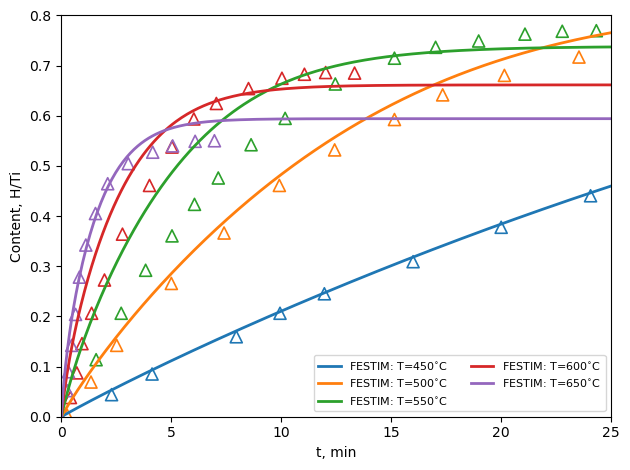

In [1]:
import festim as F
import fenics as f
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

################### PARAMETERS ###################
N_A_const = 6.022e23  # Avogadro, mol^-1
e = 1.602e-19
M_H2 = 2.016e-3 / N_A_const  # the H2 mass, kg mol^-1

# Sample size
A = 1e-2 * 1.3e-2  # Ti surface area (1cm x 1.3cm), m^2
L = 1e-3 / 2  # Ti thickness, m
V = A * L  # Ti volume (1cm x 1.3cm x 1mm), m^-3

# Ti properties
X_max = 3
n_b = 9.4e4 * N_A_const  #  the number of atomic sites per unit of volume of Ti, m^-3
n_surf = (
    X_max * 2.16e-5 * N_A_const
)  # the number of atomic sites per unit of surface area of Ti, m^-2
N_Ti = n_b * V  #  the number of moles of Ti
n_IS = X_max * n_b
lambda_Ti = n_surf / n_IS

# Properties of fluxes
E_diff = F.kJmol_to_eV(5.3e4 / 1e3)  # diffusion activation energy, eV
D0 = 9e-7  # Diffusion pre-factor for D in W, m^2 s^-1

E_des = F.kJmol_to_eV(1.17e5 / 1e3)  # activateion energy for desorption, eV
k_des = (
    1.08e8 * (2.016 / 1.00784) * N_A_const
)  # frequency factor for the surface desorption

E_sb = F.kJmol_to_eV(
    1.18e5 / 1e3
)  # the activation energy value for the inward subsurface transport, eV
k_sb = 1.16e11  # frequency factor for the inward subsurface transport, s^-1

E_bs = F.kJmol_to_eV(
    8.5e4 / 1e3
)  # the activation energy value for the outward subsurface transport, eV
k_bs = 3.24e9  # frequency factor for the outward subsurface transport, s^-1

# Chamber
V_ch = 2.95e-3  # the chamber volume, m^-3
P0 = 1.3e4  # the initial pressure, Pa


################### FUNCTIONS ###################
def S0(T):
    # the capturing coefficient
    return 0.0143 * f.exp(F.kJmol_to_eV(1.99) / F.k_B / T)


def P_H2(T, X):
    # partial pressure of hydrogen, Pa
    X0 = 0
    return F.k_B * T * e / V_ch * (P0 * V_ch / (F.k_B * T * e) + (X0 - X) * N_Ti / 2)


def J_vs(T, surf_conc, X):
    J_ads = (
        2
        * S0(T)
        * (1 - surf_conc / n_surf) ** 2
        * P_H2(T, X)
        / (2 * np.pi * M_H2 * F.k_B * T * e) ** 0.5
    )
    J_des = k_des * (surf_conc / n_surf) ** 2 * f.exp(-E_des / F.k_B / T)
    return J_ads - J_des


def K_sb(T, surf_conc, X):
    return k_sb * f.exp(-E_sb / F.k_B / T)


def K_bs(T, surf_conc, X):
    return k_bs * f.exp(-E_bs / F.k_B / T)


################### CUSTOM MODEL CLASS ###################
class CustomSimulation(F.Simulation):
    def iterate(self):
        super().iterate()

        # Content
        surf = f.assemble(
            self.h_transport_problem.boundary_conditions[0].solutions[0]
            * self.mesh.ds(1)
        )
        X = 2 * (f.assemble(self.mobile.solution * self.mesh.dx) + surf) * A / N_Ti

        # Update surface and subsurface concentrations
        self.h_transport_problem.boundary_conditions[0].prms["X"].assign(X)


colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
################### MODEL ###################
for i, T0 in enumerate([450 + 273, 500 + 273, 550 + 273, 600 + 273, 650 + 273]):
    Ti_model_impl = CustomSimulation(log_level=40)

    # Mesh
    vertices = np.linspace(0, L, num=251)
    Ti_model_impl.mesh = F.MeshFromVertices(np.sort(vertices))

    # Materials
    Ti_model_impl.materials = F.Material(id=1, D_0=D0, E_D=E_diff)

    surf_conc = F.SurfaceKinetics(
        k_bs=K_bs,
        k_sb=K_sb,
        lambda_IS=lambda_Ti,
        n_surf=n_surf,
        n_IS=n_IS,
        J_vs=J_vs,
        surfaces=1,
        initial_condition=0,
        X=0,
    )

    Ti_model_impl.boundary_conditions = [surf_conc]

    Ti_model_impl.T = F.Temperature(value=T0)

    derived_quantities = F.DerivedQuantities(
        [F.AdsorbedHydrogen(surface=1), F.TotalVolume(field="solute", volume=1)]
    )

    Ti_model_impl.exports = [derived_quantities]

    Ti_model_impl.dt = F.Stepsize(
        initial_value=1e-3, stepsize_change_ratio=1.1, max_stepsize=5, dt_min=1e-4
    )

    Ti_model_impl.settings = F.Settings(
        absolute_tolerance=1e5,
        relative_tolerance=1e-5,
        maximum_iterations=50,
        final_time=25 * 60,
    )

    Ti_model_impl.initialise()
    Ti_model_impl.run()

    retention = np.array(derived_quantities[0].data) + np.array(
        derived_quantities[1].data
    )
    t = np.array(derived_quantities.t)

    plt.plot(
        t / 60,
        retention * A / N_Ti,
        color=colors[i],
        lw=2,
        label=f"FESTIM: T={T0-273}" + r"$^{\circ}$C",
        ls="solid",
    )

    exp = pd.read_csv(f"./exp_data/{T0-273}.csv", header=None, skiprows=1, sep=",")
    plt.scatter(
        exp[0],
        exp[1],
        edgecolors=colors[i],
        facecolors="none",
        marker="^",
        s=75,
        linewidths=1.2,
    )

plt.ylabel("Content, H/Ti", fontsize=10)
plt.xlabel("t, min", fontsize=10)
plt.ylim(0, 0.8)
plt.xlim(0, 25)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.legend(fontsize=8, ncols=2)
plt.tight_layout()
plt.show()

##### Parameters from the older paper: Hamamoto, Y., Uchikoshi, T., & Tanabe, K. (2020). Comprehensive modeling of hydrogen transport and accumulation in titanium and zirconium. Nuclear Materials and Energy, 23, 100751.

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
100.0 %        1.5e+03 s    Elapsed time so far: 4.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.5e+03 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.5e+03 s    Elapsed time so far: 2.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.5e+03 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.5e+03 s    Elapsed time so

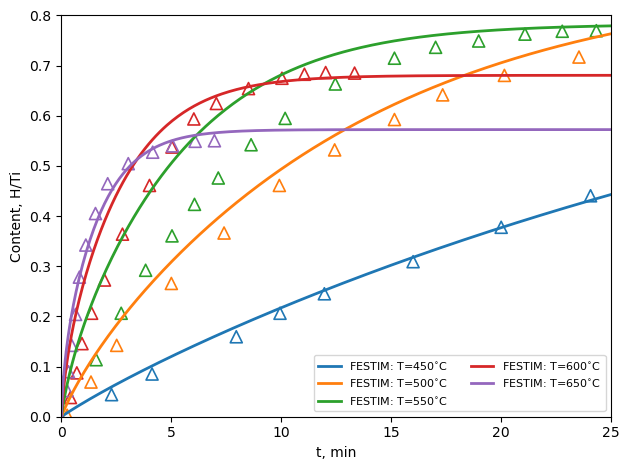

In [2]:
import festim as F
import fenics as f
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

################### PARAMETERS ###################
N_A_const = 6.022e23  # Avogadro, mol^-1
e = 1.602e-19
M_H2 = 2.016e-3 / N_A_const  # the H2 mass, kg mol^-1

# Sample size
A = 1e-2 * 1.3e-2  # Ti surface area (1cm x 1.3cm), m^2
L = 1e-3 / 2  # Ti thickness, m
V = A * L  # Ti volume (1cm x 1.3cm x 1mm), m^-3

# Ti properties
N_b = 9.4e4 * N_A_const  #  the number of atomic sites per unit of volume of Ti, m^-3
N_s = (
    2.16e-5 * N_A_const
)  # the number of atomic sites per unit of surface area of Ti, m^-2
n_Ti = N_b * V  #  the number of moles of Ti
lambda_Ti = N_s / N_b

# Properties of fluxes
E_diff = F.kJmol_to_eV(5.3e4 / 1e3)  # diffusion activation energy, eV
D0 = 9e-7  # Diffusion pre-factor for D in W, m^2 s^-1

E_des = F.kJmol_to_eV(1.17e5 / 1e3)  # activateion energy for desotpion, eV
k_des = 2.16e8 * N_A_const  # frequency factor for the surface desorption

E_sb = F.kJmol_to_eV(
    1.36e5 / 1e3
)  # the activation energy value for the inward subsurface transport, eV
k_sb = 8.56e12  # frequency factor for the inward subsurface transport, s^-1

E_bs = F.kJmol_to_eV(
    1.6e5 / 1e3
)  # the activation energy value for the outward subsurface transport, eV
k_bs = 7.77e13  # frequency factor for the outward subsurface transport, s^-1

# Chamber
V_ch = 2.95e-3  # the chamber volume, m^-3
P0 = 1.3e4  # the initial pressure, Pa


################### FUNCTIONS ###################
def S0(T):
    # the capturing coefficient
    return 0.0143 * f.exp(F.kJmol_to_eV(1.99) / F.k_B / T)


def P_H2(T, X):
    # partial pressure of hydrogen, Pa
    X0 = 0
    return (
        F.k_B * T * e / V_ch * (P0 * V_ch / (F.k_B * T * e) + (X0 - X) * (2 * n_Ti) / 2)
    )


def J_vs(T, surf_conc, X):
    J_ads = (
        2
        * S0(T)
        * (1 - surf_conc / N_s) ** 2
        * P_H2(T, X)
        / (2 * np.pi * M_H2 * F.k_B * T * e) ** 0.5
    )
    J_des = k_des * (surf_conc / N_s) ** 2 * f.exp(-E_des / F.k_B / T)
    return J_ads - J_des


def K_sb(T, surf_conc, X):
    return k_sb * f.exp(-E_sb / F.k_B / T)


def K_bs(T, surf_conc, X):
    return k_bs * f.exp(-E_bs / F.k_B / T)


################### CUSTOM MODEL CLASS ###################
class CustomSimulation(F.Simulation):
    def iterate(self):
        super().iterate()

        # Content
        X = (f.assemble(self.mobile.solution * self.mesh.dx)) * A / n_Ti

        # Update surface and subsurface concentrations
        self.h_transport_problem.boundary_conditions[0].prms["X"].assign(X)


colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
################### MODEL ###################
for i, T0 in enumerate([450 + 273, 500 + 273, 550 + 273, 600 + 273, 650 + 273]):
    Ti_model_impl = CustomSimulation(log_level=40)

    # Mesh
    vertices = np.linspace(0, L, num=501)
    Ti_model_impl.mesh = F.MeshFromVertices(np.sort(vertices))

    # Materials
    Ti_model_impl.materials = F.Material(id=1, D_0=D0, E_D=E_diff)

    surf_conc = F.SurfaceKinetics(
        k_bs=K_bs,
        k_sb=K_sb,
        lambda_IS=lambda_Ti,
        n_surf=N_s,
        n_IS=N_b,
        J_vs=J_vs,
        surfaces=1,
        initial_condition=0,
        X=0,
    )

    Ti_model_impl.boundary_conditions = [surf_conc]

    Ti_model_impl.T = F.Temperature(value=T0)

    derived_quantities = F.DerivedQuantities(
        [F.AdsorbedHydrogen(surface=1), F.TotalVolume(field="solute", volume=1)]
    )

    Ti_model_impl.exports = [derived_quantities]

    Ti_model_impl.dt = F.Stepsize(
        initial_value=1e-3, stepsize_change_ratio=1.1, max_stepsize=5, dt_min=1e-4
    )

    Ti_model_impl.settings = F.Settings(
        absolute_tolerance=1e5,
        relative_tolerance=1e-5,
        maximum_iterations=50,
        final_time=25 * 60,
    )

    Ti_model_impl.initialise()
    Ti_model_impl.run()

    retention = np.array(derived_quantities[0].data) + np.array(
        derived_quantities[1].data
    )
    t = np.array(derived_quantities.t)

    plt.plot(
        t / 60,
        retention * A / N_Ti,
        color=colors[i],
        lw=2,
        label=f"FESTIM: T={T0-273}" + r"$^{\circ}$C",
        ls="solid",
    )

    exp = pd.read_csv(f"./exp_data/{T0-273}.csv", header=None, skiprows=1, sep=",")
    plt.scatter(
        exp[0],
        exp[1],
        edgecolors=colors[i],
        facecolors="none",
        marker="^",
        s=75,
        linewidths=1.2,
    )

plt.ylabel("Content, H/Ti", fontsize=10)
plt.xlabel("t, min", fontsize=10)
plt.ylim(0, 0.8)
plt.xlim(0, 25)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.legend(fontsize=8, ncols=2)
plt.tight_layout()
plt.show()